# Import Library & CSV

In [389]:
!gdown --id 1QPWiTnxCb5td5o5WzWwCZhyzp9ziLBb0
!pip install transformers
!pip install datasets

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1QPWiTnxCb5td5o5WzWwCZhyzp9ziLBb0
To: /content/clean_data.csv
100% 97.3k/97.3k [00:00<00:00, 93.7MB/s]
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [390]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
from datasets import load_metric

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
import numpy as np

In [391]:
df = pd.read_csv('clean_data.csv')

In [392]:
df.replace("", float("NaN"), inplace=True)
df.dropna(inplace=True)

df = df[['data', 'label']]

In [393]:
df.sample(10)

,data,label
661,anjir angga menang banyak coba saja gue yang l...,Non_Misogyny
220,lanjut tempat sepi bos,Misogyny
155,duh enak kalo diremes,Misogyny
677,mengapa sih perempuan kerja sudah nikah saja,Misogyny
910,luar mulia dalam muslihat memang benar bungkus...,Misogyny
168,jangan pernah buka hijab,Non_Misogyny
1107,mood banget kalo sudah bikin konten dua,Non_Misogyny
113,kayak sudah sah suami istri saja,Non_Misogyny
605,heh masih enggak sadar key benerin dulu gigi i...,Misogyny
536,biar mereka yang tau dan tanggung semua,Non_Misogyny


In [394]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1223 entries, 0 to 1222
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    1223 non-null   object
 1   label   1223 non-null   object
dtypes: object(2)
memory usage: 28.7+ KB


In [395]:
df.label.value_counts()

Non_Misogyny    729
Misogyny        494
Name: label, dtype: int64

# Eksplorasi & Split Dataset

In [396]:
def show_plot(df):
  plt.figure(figsize=(5, 5))
  sns.countplot(x=df['label'])

  # orange_patch = mpatches.Patch(color='tab:orange', label='misogyny')
  # blue_patch = mpatches.Patch(color='tab:blue', label='non misogyny')
  # plt.legend(handles=[orange_patch, blue_patch])

  plt.show()

In [397]:
print(f'Total: {len(df)}')

Total: 1223


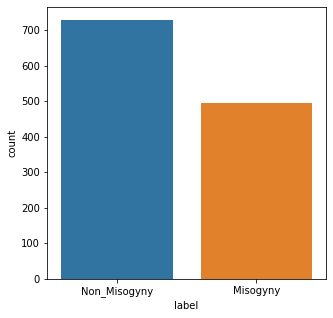

In [398]:
show_plot(df)

## Data Splitting

In [399]:
def oversample(df):
    classes = df.label.value_counts().to_dict()
    most = max(classes.values())
    classes_list = []
    for key in classes:
        classes_list.append(df[df['label'] == key]) 
    classes_sample = []
    for i in range(1,len(classes_list)):
        classes_sample.append(classes_list[i].sample(most, replace=True))
    df_maybe = pd.concat(classes_sample)
    final_df = pd.concat([df_maybe,classes_list[0]], axis=0)
    final_df = final_df.reset_index(drop=True)
    return final_df

In [400]:
df["label"] = df["label"].map({'Non_Misogyny': 0, 'Misogyny': 1})

In [401]:
RANDOM_SEED = 30

df_train, df_test = train_test_split(
    df,
    test_size=0.25,
    random_state=RANDOM_SEED,
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.4,
    random_state=RANDOM_SEED,
)

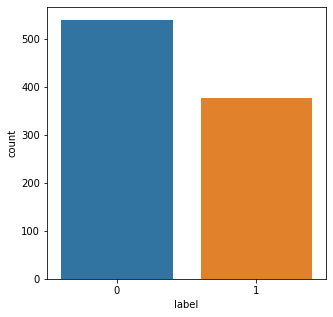

In [402]:
show_plot(df_train)

In [403]:
# df_train = oversample(df_train)

In [404]:
df_train.label.value_counts()

0    540
1    377
Name: label, dtype: int64

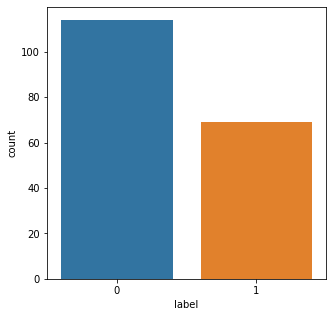

In [405]:
show_plot(df_val)

In [406]:
df_val.label.value_counts()

0    114
1     69
Name: label, dtype: int64

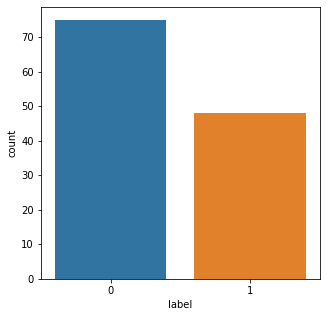

In [407]:
show_plot(df_test)

In [408]:
df_test.label.value_counts()

0    75
1    48
Name: label, dtype: int64

In [409]:
print(f'Total Train: {len(df_train)}')
print(f'Total Val  : {len(df_val)}')
print(f'Total Test : {len(df_test)}')

Total Train: 917
Total Val  : 183
Total Test : 123


# 

In [410]:
actual_label = df_test['label']

In [411]:
df_train.to_csv("train.csv", index=False)
df_val.to_csv("eval.csv", index=False)
df_test.to_csv("test.csv", index=False)

In [412]:
from datasets import load_dataset

files = {
    "train": "train.csv", 
    "eval": "eval.csv", 
    "test": "test.csv",
}

dataset = load_dataset('csv', data_files=files)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-a0efaf01a16c178a/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

# Tokenize Dataset

In [413]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--indobenchmark--indobert-base-p2/snapshots/94b4e0a82081fa57f227fcc2024d1ea89b57ac1f/config.json
Model config BertConfig {
  "_name_or_path": "indobenchmark/indobert-base-p2",
  "_num_labels": 5,
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "

In [414]:
def tokenize_function(text):
  return tokenizer(text["data"], padding='max_length', max_length=256)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [415]:
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["eval"]

# Train

In [416]:
import torch
torch.cuda.empty_cache()

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [417]:
model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", num_labels=2)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--indobenchmark--indobert-base-p2/snapshots/94b4e0a82081fa57f227fcc2024d1ea89b57ac1f/config.json
Model config BertConfig {
  "_name_or_path": "indobenchmark/indobert-base-p2",
  "_num_labels": 5,
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1",
  "type_vocab_size

In [418]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    "test_trainer", 
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    learning_rate=3e-6,
    evaluation_strategy="epoch", 
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [419]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return metric.compute(predictions=predictions, references=labels)

torch.cuda.empty_cache()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

training_history = trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: data. If data are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 917
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1150


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.514254,0.770492
2,No log,0.427307,0.830601
3,No log,0.413308,0.803279
4,No log,0.444092,0.803279
5,0.422200,0.459806,0.814208
6,0.422200,0.489372,0.836066
7,0.422200,0.550234,0.830601
8,0.422200,0.578750,0.836066
9,0.162800,0.604017,0.830601
10,0.162800,0.614122,0.830601


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: data. If data are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 183
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: data. If data are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 183
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: data. If data are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 183
  Batch size = 8
The following colum

# Evaluate

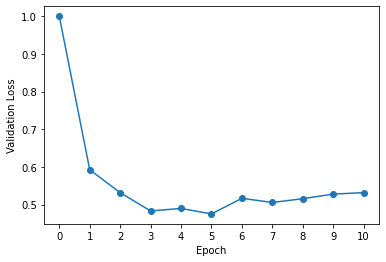

In [420]:
plt.plot([1, 0.592546, 0.531775, 0.483205, 0.489818, 0.475328, 0.516793, 0.505685, 0.515740, 0.527881, 0.531886], marker='o')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.show()

In [421]:
evaluation_history = trainer.evaluate()
evaluation_history

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: data. If data are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 183
  Batch size = 8


{'eval_loss': 0.614121675491333,
 'eval_accuracy': 0.8306010928961749,
 'eval_runtime': 2.9324,
 'eval_samples_per_second': 62.405,
 'eval_steps_per_second': 7.843,
 'epoch': 10.0}

In [422]:
test_dataset = tokenized_datasets["test"]

prediction = trainer.predict(test_dataset)
prediction = prediction.predictions.argmax(1)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: data. If data are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 123
  Batch size = 8


In [423]:
print(classification_report(prediction, actual_label, target_names=["non misogyny", "misogyny"]))

              precision    recall  f1-score   support

non misogyny       0.88      0.86      0.87        77
    misogyny       0.77      0.80      0.79        46

    accuracy                           0.84       123
   macro avg       0.83      0.83      0.83       123
weighted avg       0.84      0.84      0.84       123



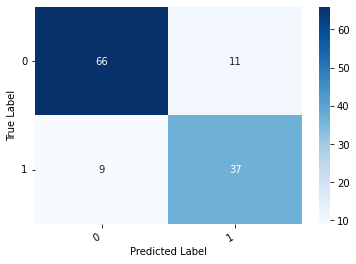

In [424]:
def show_confusion_matrix(confusion_matrix):
        hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
        hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')

        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

cm = confusion_matrix(prediction, actual_label)
show_confusion_matrix(cm)

In [425]:
df_test_coba=df_test
df_test_coba['predicted'] = prediction

df_test_coba.to_csv('predicted_result.csv', index=False)

In [426]:
from sklearn.model_selection import KFold

n=5
kf = KFold(n_splits=n, random_state=30, shuffle=True)

results = []

for train_index, val_index in kf.split(df_train):
  # splitting Dataframe (dataset not included)
  df_cv_train = df_train.iloc[train_index]
  df_cv_eval = df_train.iloc[val_index]
  
  df_cv_train.to_csv("cv_train.csv", index=False)
  df_cv_eval.to_csv("cv_eval.csv", index=False)

  files = {
    "train": "cv_train.csv", 
    "eval": "cv_eval.csv",
  }

  dataset_cv = load_dataset('csv', data_files=files)

  tokenized_datasets_cv = dataset_cv.map(tokenize_function, batched=True)

  torch.cuda.empty_cache()

  cv_train_dataset = tokenized_datasets_cv["train"]
  cv_eval_dataset = tokenized_datasets_cv["eval"]

  cv_model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", num_labels=2)

  cv_trainer = Trainer(
    model=cv_model,
    args=training_args,
    train_dataset=cv_train_dataset,
    eval_dataset=cv_eval_dataset,
    compute_metrics=compute_metrics,
  )

  #train
  training_history = cv_trainer.train()

  # evaluate
  evaluation_history_cv = cv_trainer.evaluate()
  results.append(evaluation_history_cv['eval_accuracy'])

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-f7a1d7f9aad461ad/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--indobenchmark--indobert-base-p2/snapshots/94b4e0a82081fa57f227fcc2024d1ea89b57ac1f/config.json
Model config BertConfig {
  "_name_or_path": "indobenchmark/indobert-base-p2",
  "_num_labels": 5,
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1",
  "type_vocab_size

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.567064,0.722826
2,No log,0.503018,0.750000
3,No log,0.501876,0.733696
4,No log,0.519230,0.782609
5,No log,0.537279,0.760870
6,0.417400,0.566739,0.793478
7,0.417400,0.600837,0.793478
8,0.417400,0.635727,0.760870
9,0.417400,0.654615,0.788043
10,0.417400,0.663248,0.788043


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: data. If data are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 184
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: data. If data are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 184
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: data. If data are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 184
  Batch size = 8
The following colum

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-d39ddd577b3b4ee6/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--indobenchmark--indobert-base-p2/snapshots/94b4e0a82081fa57f227fcc2024d1ea89b57ac1f/config.json
Model config BertConfig {
  "_name_or_path": "indobenchmark/indobert-base-p2",
  "_num_labels": 5,
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1",
  "type_vocab_size

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.560598,0.722826
2,No log,0.505134,0.750000
3,No log,0.461042,0.760870
4,No log,0.478514,0.777174
5,No log,0.472964,0.755435
6,0.406600,0.514503,0.798913
7,0.406600,0.529886,0.793478
8,0.406600,0.561677,0.788043
9,0.406600,0.586015,0.793478
10,0.406600,0.593748,0.788043


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: data. If data are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 184
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: data. If data are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 184
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: data. If data are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 184
  Batch size = 8
The following colum

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-f50462954034e0db/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--indobenchmark--indobert-base-p2/snapshots/94b4e0a82081fa57f227fcc2024d1ea89b57ac1f/config.json
Model config BertConfig {
  "_name_or_path": "indobenchmark/indobert-base-p2",
  "_num_labels": 5,
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1",
  "type_vocab_size

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.587578,0.590164
2,No log,0.416354,0.825137
3,No log,0.426343,0.781421
4,No log,0.460080,0.765027
5,No log,0.420776,0.792350
6,0.399600,0.424377,0.819672
7,0.399600,0.459317,0.814208
8,0.399600,0.505696,0.797814
9,0.399600,0.533763,0.797814
10,0.399600,0.536160,0.803279


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: data. If data are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 183
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: data. If data are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 183
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: data. If data are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 183
  Batch size = 8
The following colum

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-e368c7497111b359/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--indobenchmark--indobert-base-p2/snapshots/94b4e0a82081fa57f227fcc2024d1ea89b57ac1f/config.json
Model config BertConfig {
  "_name_or_path": "indobenchmark/indobert-base-p2",
  "_num_labels": 5,
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1",
  "type_vocab_size

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.546568,0.754098
2,No log,0.509647,0.748634
3,No log,0.531037,0.754098
4,No log,0.552196,0.775956
5,No log,0.606987,0.743169
6,0.386600,0.656894,0.754098
7,0.386600,0.733628,0.786885
8,0.386600,0.768218,0.765027
9,0.386600,0.805854,0.770492
10,0.386600,0.812359,0.765027


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: data. If data are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 183
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: data. If data are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 183
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: data. If data are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 183
  Batch size = 8
The following colum

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-cb52c4af2aac8014/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--indobenchmark--indobert-base-p2/snapshots/94b4e0a82081fa57f227fcc2024d1ea89b57ac1f/config.json
Model config BertConfig {
  "_name_or_path": "indobenchmark/indobert-base-p2",
  "_num_labels": 5,
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1",
  "type_vocab_size

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.571029,0.699454
2,No log,0.515262,0.743169
3,No log,0.472388,0.765027
4,No log,0.476477,0.775956
5,No log,0.523533,0.759563
6,0.403900,0.563844,0.770492
7,0.403900,0.604844,0.775956
8,0.403900,0.605691,0.759563
9,0.403900,0.638342,0.748634
10,0.403900,0.655218,0.748634


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: data. If data are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 183
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: data. If data are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 183
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: data. If data are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 183
  Batch size = 8
The following colum

In [427]:
print("results",results)
print(f"Mean-Validation: {sum(results) / len(results)}")

results [0.7880434782608695, 0.7880434782608695, 0.8032786885245902, 0.7650273224043715, 0.7486338797814208]
Mean-Validation: 0.7786053694464243


# save model

In [428]:
model.save_pretrained("model")

Configuration saved in model/config.json
Model weights saved in model/pytorch_model.bin


In [429]:
trainer = Trainer(model=model)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [430]:
from numpy.ma.core import exp
def logits_converter(logits):
  odds = exp(logits)
  return odds / (1 + odds)

In [431]:
def predict(text):
    tokenized = tokenizer(text, padding='max_length', max_length=256)
    all_label = trainer.predict([tokenized],).predictions
    label = all_label.argmax(1)[0]
    if label == 0:
        print(f'Predicted: Non Misogyny [{label}]')
    else:
        print(f'Predicted: Misogyny [{label}]')
    
    print('non misogyny : ', logits_converter(all_label[0][0]))
    print('misogyny : ', logits_converter(all_label[0][1]))

In [432]:
predict("""
    dasar cewek lonte memeklu
""")

***** Running Prediction *****
  Num examples = 1
  Batch size = 8


Predicted: Misogyny [1]
non misogyny :  0.06559386598146104
misogyny :  0.9667722420503955


In [433]:
predict("""
    tolong ya ges sesama cewek jangan saling menyalahkan okayy
""")

***** Running Prediction *****
  Num examples = 1
  Batch size = 8


Predicted: Non Misogyny [0]
non misogyny :  0.9442701303383857
misogyny :  0.026197619310709103


In [434]:
predict("""
    udahlah, perempuan itu di rumah aja, ga usah sekolah tinggi-tinggi, nikah dan buat anak
""")

***** Running Prediction *****
  Num examples = 1
  Batch size = 8


Predicted: Misogyny [1]
non misogyny :  0.43070775819931284
misogyny :  0.5008868611920478


In [435]:
predict("""
    ngeprank sih malah ngegodaa haha
""")

***** Running Prediction *****
  Num examples = 1
  Batch size = 8


Predicted: Misogyny [1]
non misogyny :  0.0823428731361509
misogyny :  0.9227022884140492


In [436]:
predict("""
    ya ampunn ngakak, burik banget si lu
""")

***** Running Prediction *****
  Num examples = 1
  Batch size = 8


Predicted: Misogyny [1]
non misogyny :  0.14761702850455774
misogyny :  0.8300895096829402
